# **Pré-requisitos**

In [1]:
# Instalar dependências do python
%pip install gensim
%pip install pyLDAvis
%pip install wordcloud

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Importar bibliotecas necessárias para este projeto
from collections import Counter
from gensim.corpora import Dictionary
from gensim.models import TfidfModel, CoherenceModel
from gensim.models.ldamodel import LdaModel
from matplotlib import pyplot as plt
from wordcloud import WordCloud
import pandas as pd
import seaborn as sns

# **Analisando termos**

In [3]:
# Carregar o dataset mais atual
df = pd.read_csv('data/Leis de Sorocaba (Clean).csv')

In [4]:
df

,summary
0,dispor sobre denominação José antonio pascoto ...
1,dispor sobre denominação vitor hage via públic...
2,dispor sobre denominação lisardo cunha dia via...
3,dispor sobre denominação Desirre Ferraz Cardos...
4,instituir calendário oficial município dia soc...
...,...
12807,dispor sobre abertura crédito especial cr$ TOK...
12808,dispor sobre concessão auxílio dar outro provi...
12809,dispor sobre concessão licença prêmio funcioná...
12810,dispor sobre apreensão eliminação animal


In [5]:
# Exibir as 30 palavras mais frequentes no corpus
def plot_30_most_frequent_words(words):
  counter = Counter(words.split())
  most_frequent = counter.most_common(30)

  # Fazer um gráfico de barras das palavras frequentes
  fig = plt.figure(1, figsize = (20,10))
  _ = pd.DataFrame(most_frequent, columns=("words","count"))
  sns.barplot(x = 'words', y = 'count', data = _, palette = 'winter')
  plt.xticks(rotation=45);

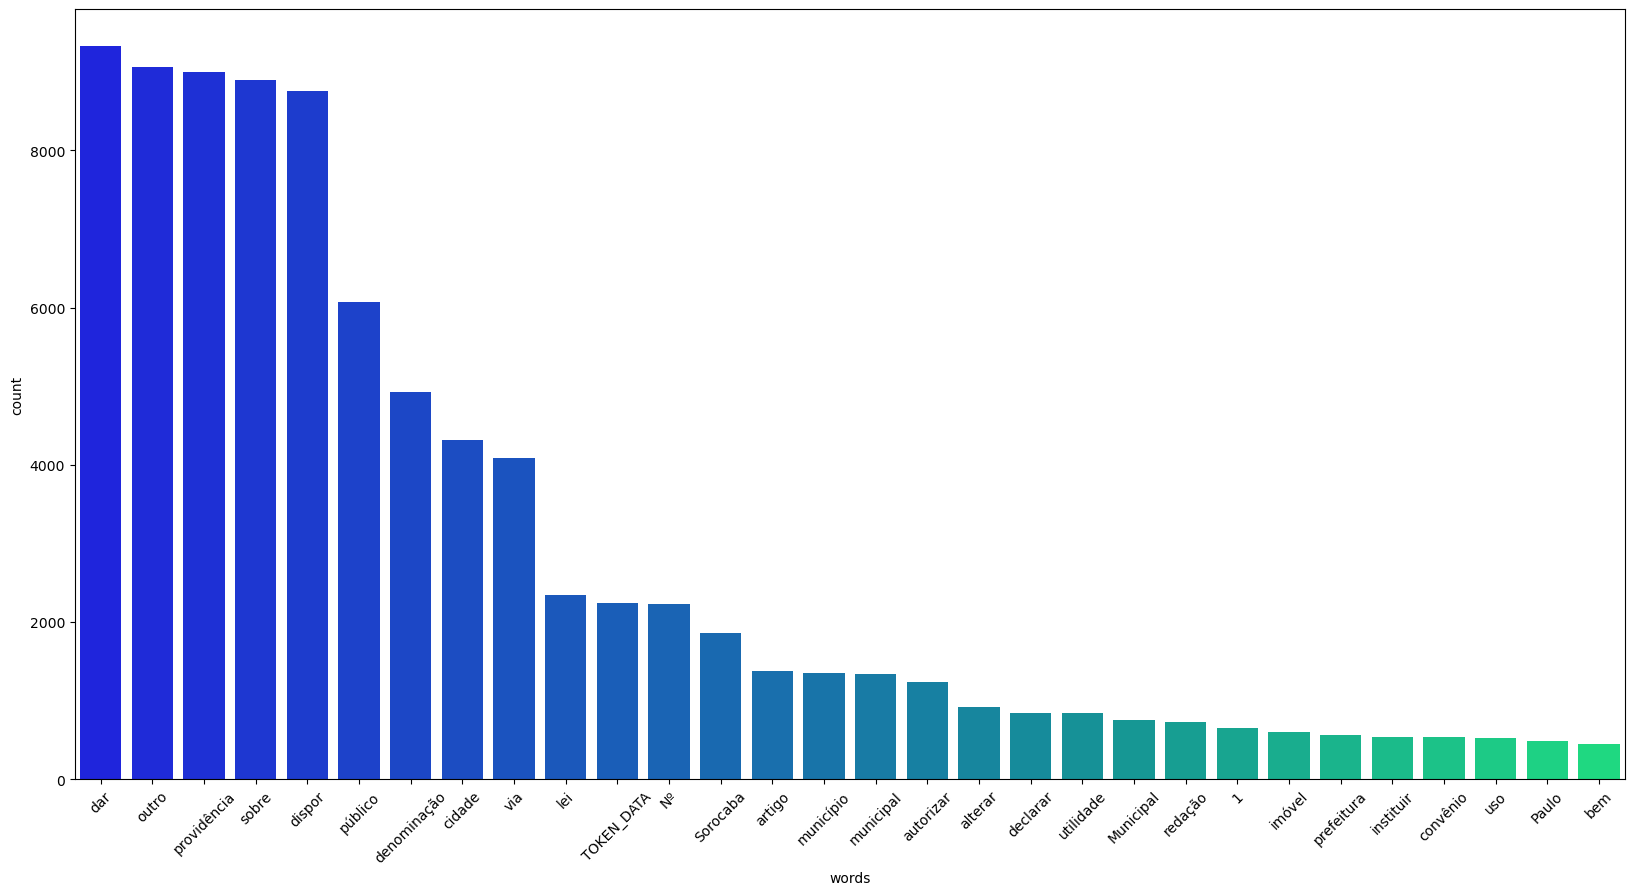

In [6]:
# Unir todas as palavras do corpus
summary_words = ' '.join(list(df['summary'].fillna('').values))

plot_30_most_frequent_words(summary_words)

Parece que temos termos que são muito frequentes e que não adicionam contexto às nossas leis.

Poderíamos removê-los, para melhorar nossa análise.

In [7]:
df['summary'].str.contains('dispor sobre').sum()

8667

In [8]:
df['summary'].str.contains('dar outro providência').sum()

8963

In [9]:
df['summary'].str.contains('dar outro providencia').sum()

12

Vamos remover as seguintes frases do nosso dataset:

* dispor sobre
* dar outro providência
* dar outro providencia

In [10]:
# Lista de frases a serem removidas
remove_phrases = ['dispor sobre', 'dar outro providência', 'dar outro providencia']

# Junta as frases com o operador OR para o regex
remove_phrases_regex = '|'.join(remove_phrases)

# Remove as frases
df['summary'] = df['summary'].str.replace(remove_phrases_regex, ' ', regex=True).str.strip()

In [11]:
df

,summary
0,denominação José antonio pascoto via público
1,denominação vitor hage via público
2,denominação lisardo cunha dia via público
3,denominação Desirre Ferraz Cardoso via público...
4,instituir calendário oficial município dia soc...
...,...
12807,abertura crédito especial cr$ TOKEN_VALOR
12808,concessão auxílio
12809,concessão licença prêmio funcionário municipal
12810,apreensão eliminação animal


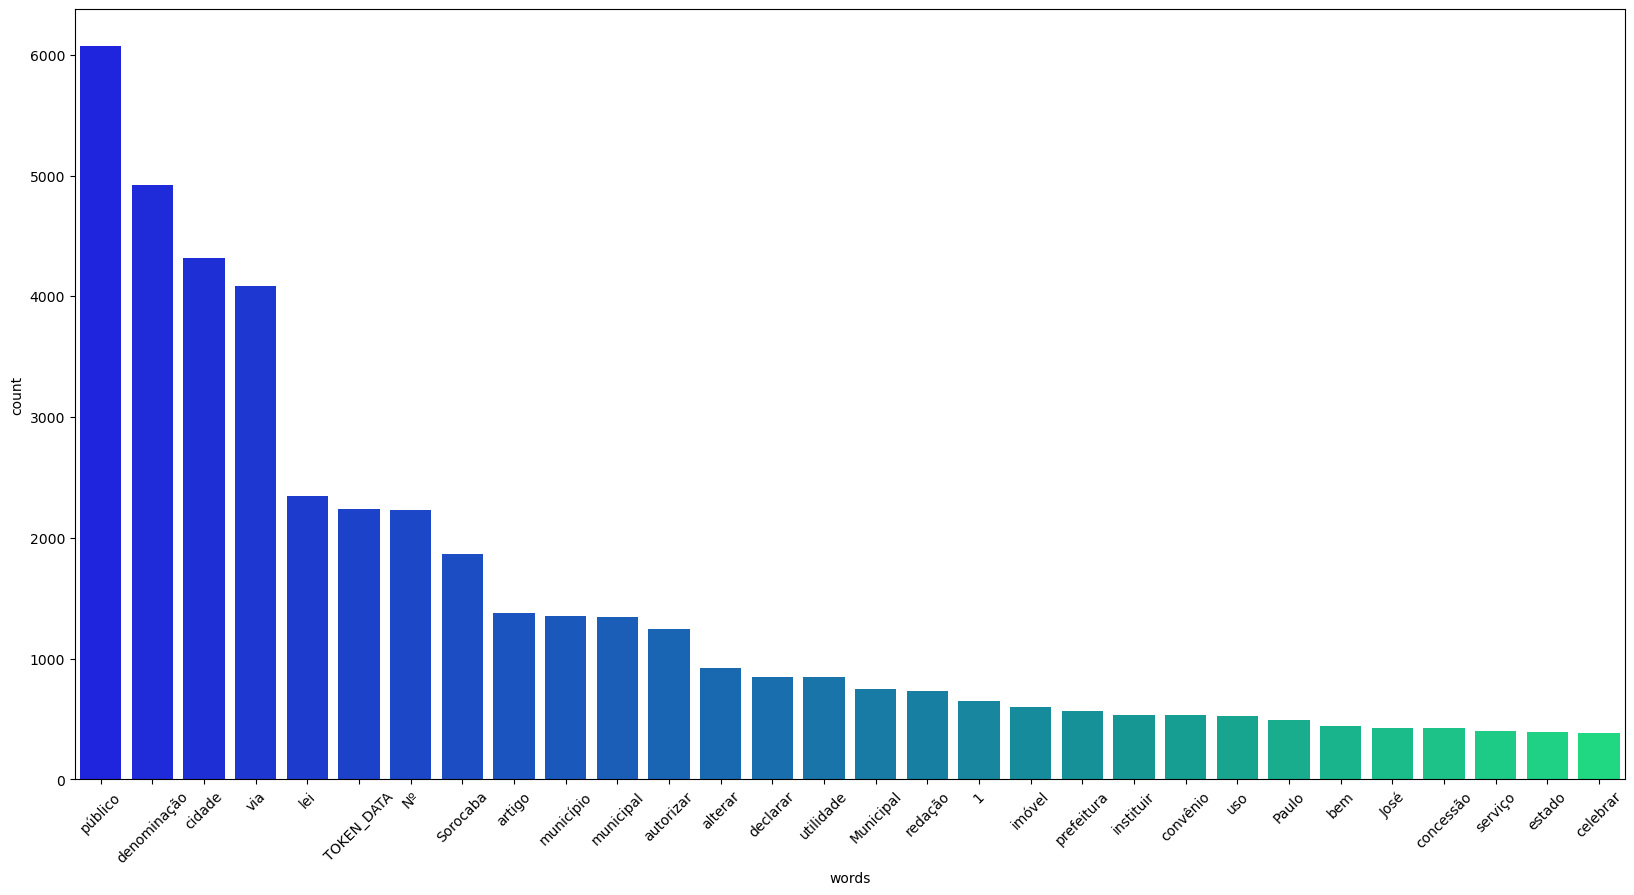

In [17]:
# Exibir novamente as 30 palavras mais frequentes
summary_words = ' '.join(list(df['summary'].fillna('').values))

plot_30_most_frequent_words(summary_words)

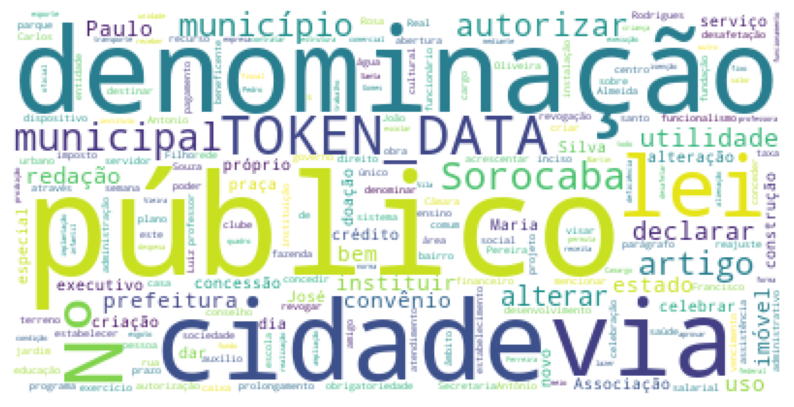

In [18]:
# Fazer uma núvem de palavras da legislação de Sorocaba
wordcloud = WordCloud(background_color="white",
                      max_words= 200,
                      contour_width = 8,
                      contour_color = "steelblue",
                      collocations=False).generate(summary_words)

fig = plt.figure(1, figsize = (10, 10))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

# **Modelagem de Tópicos**

In [19]:
words_vec = list(df['summary'].fillna('').str.split())

In [20]:
words_vec[:5]

[['denominação', 'José', 'antonio', 'pascoto', 'via', 'público'],
 ['denominação', 'vitor', 'hage', 'via', 'público'],
 ['denominação', 'lisardo', 'cunha', 'dia', 'via', 'público'],
 ['denominação', 'Desirre', 'Ferraz', 'Cardoso', 'via', 'público', 'cidade'],
 ['instituir', 'calendário', 'oficial', 'município', 'dia', 'sociólogo']]

In [21]:
dct = Dictionary(words_vec)
corpus = [dct.doc2bow(line) for line in words_vec]
model = TfidfModel(corpus)

In [22]:
vector = model[corpus[0]]

In [23]:
vector

[(0, 0.2950231255861695),
 (1, 0.4740269781194957),
 (2, 0.08266973740498429),
 (3, 0.8169712983827224),
 (4, 0.06501130288228354),
 (5, 0.09877713307266041)]

In [24]:
# Exibir TF-IDF de cada palavra
{dct.get(id): value for id, value in vector}

{'José': 0.2950231255861695,
 'antonio': 0.4740269781194957,
 'denominação': 0.08266973740498429,
 'pascoto': 0.8169712983827224,
 'público': 0.06501130288228354,
 'via': 0.09877713307266041}

<Axes: xlabel='number_of_topics', ylabel='coherence_score'>

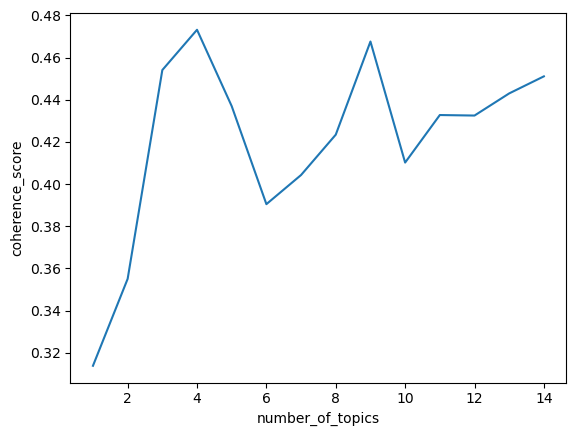

In [25]:
# Calcular a nota de coerência
number_of_topics = []
coherence_score = []
for i in range(1,15):
  lda_model = LdaModel(corpus=corpus,
                    id2word=dct,
                    iterations=50,
                    num_topics=i,
                    random_state=42)
  coherence_model_lda = CoherenceModel(model=lda_model,
                                       texts=words_vec,
                                       dictionary=dct,
                                       coherence='c_v')
  coherence_lda = coherence_model_lda.get_coherence()
  number_of_topics.append(i)
  coherence_score.append(coherence_lda)

# Criar um dataframe de nota de coerência por número de tópicos
topic_coherence = pd.DataFrame({'number_of_topics':number_of_topics,
                                'coherence_score':coherence_score})

# Exibir um gráfico de linha
sns.lineplot(data=topic_coherence, x='number_of_topics', y='coherence_score')

In [29]:
# Definir o número de tópicos
n_topics = 9

# Rodar o modelo LDA
lda_model = LdaModel(corpus=corpus,
                    id2word=dct,
                    num_topics=n_topics,
                    random_state=42,
                    update_every=1,
                    passes=10,
                    alpha='symmetric',
                    iterations=100,
                    per_word_topics=True)

In [30]:
for idx, topic in lda_model.print_topics(-1):
    print("Topic: {} Word: {}".format(idx, topic))

Topic: 0 Word: 0.065*"criação" + 0.033*"Municipal" + 0.027*"parque" + 0.020*"infantil" + 0.019*"municipal" + 0.017*"escola" + 0.017*"criar" + 0.015*"doar" + 0.011*"conselho" + 0.011*"adicional"
Topic: 1 Word: 0.078*"autorizar" + 0.051*"prefeitura" + 0.045*"municipal" + 0.038*"Paulo" + 0.038*"convênio" + 0.031*"Sorocaba" + 0.031*"estado" + 0.023*"celebrar" + 0.022*"doação" + 0.018*"Municipal"
Topic: 2 Word: 0.106*"lei" + 0.104*"Nº" + 0.098*"TOKEN_DATA" + 0.065*"artigo" + 0.034*"alterar" + 0.032*"redação" + 0.032*"1" + 0.023*"dar" + 0.019*"novo" + 0.016*"alteração"
Topic: 3 Word: 0.034*"concessão" + 0.026*"município" + 0.022*"Sorocaba" + 0.019*"mencionar" + 0.018*"auxílio" + 0.016*"serviço" + 0.015*"salarial" + 0.015*"municipal" + 0.013*"imposto" + 0.012*"público"
Topic: 4 Word: 0.054*"terreno" + 0.016*"caixa" + 0.015*"autorizar" + 0.014*"urbano" + 0.014*"município" + 0.013*"contrato" + 0.013*"executivo" + 0.012*"contratar" + 0.012*"prédio" + 0.012*"previdência"
Topic: 5 Word: 0.081*"cré

In [31]:
# Import and enable notebook to run visualization
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim_models.prepare(lda_model,
                                     corpus,
                                     dct, n_jobs=1)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.403819  0.092707       1        1  25.686432
2     -0.059168 -0.405377       2        1  17.510075
6     -0.061268  0.113836       3        1  12.052693
1      0.129716  0.092560       4        1  10.845018
7      0.083405  0.067024       5        1   9.171381
3      0.073035  0.046728       6        1   8.048580
4      0.102866 -0.002251       7        1   6.051002
0      0.067956 -0.000342       8        1   5.768842
5      0.067277 -0.004885       9        1   4.865977, topic_info=              Term         Freq        Total Category  logprob  loglift
2      denominação  4152.000000  4152.000000  Default  30.0000  30.0000
14          cidade  3931.000000  3931.000000  Default  29.0000  29.0000
5              via  3867.000000  3867.000000  Default  28.0000  28.0000
4          público  5733.000000  5733.000000  Default  27.0000  27.0000
29             lei  2102.000000  2102.000000  Default  26.0000  26.0000
...            ...          ...          ...      ...      ...      ...
10656          cr$    53.054977   143.720558   Topic9  -4.6452   2.0264
1742   autorização    67.612975   350.105432   Topic9  -4.4028   1.3785
33        Sorocaba   101.285899  1507.930108   Topic9  -3.9986   0.3224
540           água    22.903433   129.459121   Topic9  -5.4853   1.2908
1861       técnico    18.855934    41.646019   Topic9  -5.6797   2.2305

[423 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
867       6  0.969140      %
157       2  0.998061      1
110       2  0.997763      2
776       2  0.992068      3
437       2  0.989412      4
...     ...       ...    ...
74        2  0.099875   área
74        5  0.338467   área
74        7  0.427245   área
74        9  0.027743   área
890       2  0.995092  único

[512 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 3, 7, 2, 8, 4, 5, 1, 6])

Apesar de termos construído um modelo bastante simplificado, analisando somente a ementa das leis, pudemos fazer uma modelagem de tópicos bastante interessante.

É possível identificar alguns grupos claros:

* Denominações de logradouros públicos, como vias, ruas e praças
* Alteração ou revogação de outras leis
* Declarações de instituições como sendo de utilidade pública
* Autorização de convênio com instituições e outros órgãos públicos
* Concessão de créditos e remunerações

Tudo indica que, com uma maior dedicação, há grande possibilidade de construirmos um modelo satisfatório para analisar leis que podem ser revogadas ou unificadas.